In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
from seisLM.model import pretrained_models
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import torch
import einops
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-10-22h-22m-38s/checkpoints/epoch=6-step=978355.ckpt'
model = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
    model_name_or_path
)
model.eval();

In [3]:
dataset = sbd.ETHZ(
  sampling_rate=100,
  component_order="ZNE",
  dimension_order="NCW",
  cache="full"
)

eval_set = 'dev'
split = dataset.get_split(eval_set)
split.preload_waveforms(pbar=True)

task = '1'
# task = '23'

task_csv = f'/scicore/home/dokman0000/liu0003/projects/seisLM/data/targets/ethz/task{task}.csv'
task_targets = pd.read_csv(task_csv)
task_targets = task_targets[task_targets["trace_split"] == eval_set]
print(len(task_targets))

if task == '1':
  colors = ['#1f77b4' if a == 'noise' else '#ff7f0e' for a in task_targets['trace_type'].to_list()]
else:
  colors = ['#1f77b4' if a == 'P' else '#ff7f0e' for a in task_targets['phase_label'].to_list()]


2024-06-16 19:43:15,861 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
Preloading waveforms: 100%|██████████| 3632/3632 [00:22<00:00, 161.07it/s]

7264


In [4]:
task_targets

,trace_name,trace_idx,trace_split,sampling_rate,start_sample,end_sample,trace_type
20970,"bucket8$0,:3,:27701",10485,dev,100,5280,8280,earthquake
20971,"bucket8$0,:3,:27701",10485,dev,100,2357,5357,noise
20972,"bucket8$1,:3,:24001",10486,dev,100,4696,7696,earthquake
20973,"bucket8$1,:3,:24001",10486,dev,100,2063,5063,noise
20974,"bucket8$2,:3,:24001",10487,dev,100,4864,7864,earthquake
...,...,...,...,...,...,...,...
28229,"bucket37$851,:3,:24707",14114,dev,100,583,3583,noise
28230,"bucket40$51,:3,:30001",14115,dev,100,3609,6609,earthquake
28231,"bucket40$51,:3,:30001",14115,dev,100,2580,5580,noise
28232,"bucket40$52,:3,:30685",14116,dev,100,5675,8675,earthquake


In [5]:
generator = sbg.SteeredGenerator(split, task_targets)
generator.add_augmentations(
  [
        sbg.SteeredWindow(windowlen=3001, strategy="pad"),
        sbg.ChangeDtype(np.float32),
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]
)

batchsize = 8
num_workers = 4
loader = DataLoader(
    generator, batch_size=batchsize, shuffle=False, num_workers=num_workers
)

In [6]:
batch_embeddings = []

for batch in loader:
  with torch.no_grad():
    batch_embeddings.append(
      model.model(
        input_values = batch["X"].cuda()).projected_states.mean(axis=1)
    )

all_embeddings = torch.concatenate(batch_embeddings, axis=0).cpu().numpy()

In [7]:
# all_embeddings = torch.concatenate(batch_embeddings, axis=0).cpu().numpy()

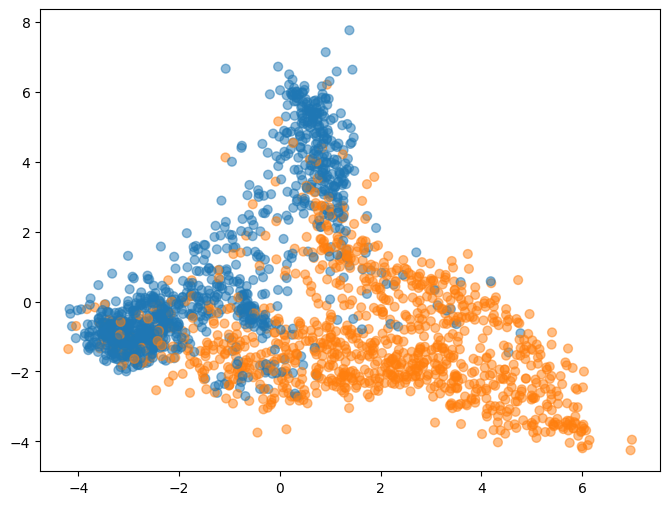

In [8]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111,)

num_points_to_show = 2000
X_reduced = PCA(n_components=2).fit_transform(all_embeddings)

scatter = ax.scatter(
    X_reduced[:, 0][:num_points_to_show],
    X_reduced[:, 1][:num_points_to_show],
    c=colors[:num_points_to_show],
    s=40,
    alpha=0.5,
)


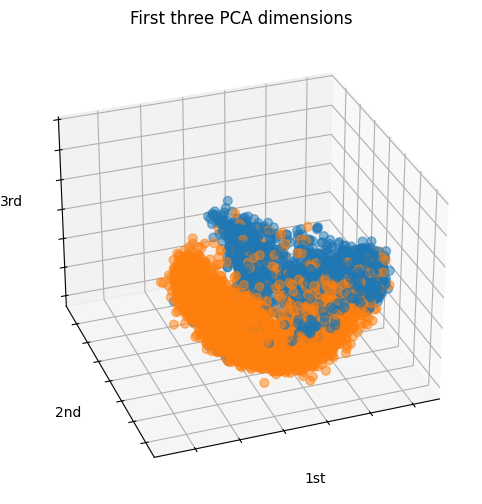

In [11]:
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

num_points_to_show = 2000

X_reduced = PCA(n_components=3).fit_transform(all_embeddings)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=colors,
    s=40,
    alpha=0.5,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd")
ax.zaxis.set_ticklabels([])

plt.show()


In [10]:
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111,)


# scatter = ax.scatter(
#     X_tsne_embedded[:, 0],
#     X_tsne_embedded[:, 1],
#     c=colors,
#     s=40,
# )